In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

np.random.seed(1)
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

data = np.genfromtxt('datasets/german_numeric')
X, y = data[:, :-1], data[:, -1]
num_samples, num_features = len(X), len(X[0])

# Preprocessing Steps
1. Check if the class label is binary and {-1, 1}, if not, transform.

In [12]:
y[y==2] = -1

2. Normalize data after splitting labels and features.

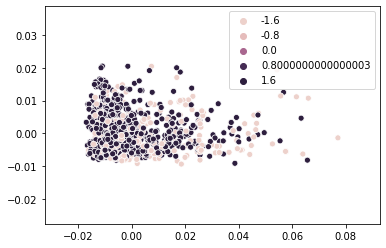

In [14]:
X = X / np.linalg.norm(X)

data_embedding = pca.fit_transform(X)
sns.scatterplot(data_embedding[:, 0], data_embedding[:, 1], hue=y)

3. Make varying features. For this one, it seems we need a more systematic way. Randomly removing features will not introduce any pattern to be learned from. Therefore, the feature removal needs to follow a pattern as well. Seems we need to remove feature following a function for starters.

**Assumptions.** 
- There must be a correlation between the error of the initial model and the feature space distribution. This is logical since a different space induces some amount of error.
- The feature availability follows an unknown underlying distribution. This also makes sense since to be able to learn from varying features, there needs to be some featurewise relationship information available. 

Let us try to model feature availability as a multivariate normal distribution.

In [15]:
cov = np.random.rand(num_features, num_features)
cov = np.dot(cov, cov.transpose())  # to have a positive semi-definite matrix
mean = np.random.rand(num_features)

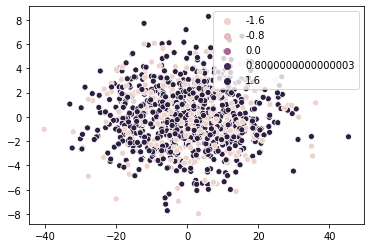

In [17]:
spaces = np.random.multivariate_normal(mean, cov, num_samples)
space_embedding = pca.fit_transform(spaces)
sns.scatterplot(space_embedding[:, 0], space_embedding[:, 1], hue=y)

We threshold the values so that the output is one-hot encoded.

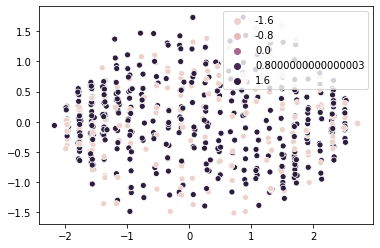

In [24]:
spaces[spaces < 0] = 0
spaces[spaces != 0] = 1
space_embedding = pca.fit_transform(spaces)
sns.scatterplot(space_embedding[:, 0], space_embedding[:, 1], hue=y)

Finally, let us pack this up as a function and use it in a prediction scenario.


In [25]:
def simulate_varying(X):
    '''Get the data and generate a varying feature space pattern.
    Possible concerns: thresholding messing up the distribution?'''
    
    # create a covariance matrix
    cov = np.random.rand(num_features, num_features)
    cov = np.dot(cov, cov.transpose())  # to have a positive semi-definite matrix
    
    # create a mean vector
    mean = np.random.rand(len(X[0]))
    
    # sample from multivariate gaussian w/ given mean and cov
    spaces = np.random.multivariate_normal(mean, cov, len(X))
    
    # threshold samples for 1-hot encoding
    spaces[spaces < 0] = 0
    spaces[spaces != 0] = 1

    return spaces

In [ ]:
# TO DO 

# def simulate_random_varying(X):
# compare performance of a simple linear model in these two scenarios
        # try this with multiple datasets
